# Predict Distributions - TopDown

Predict timing and size of distributions of ETFs

Apply a TopDown approach with using time-series models on fund level



In [1]:
# General
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import re

# File download
from tqdm.notebook import tqdm, trange

# Custom modules
from Tools import S3

# Graphics
import seaborn as sns
import matplotlib.pyplot as plt

# Hidden configurations
from mySecrets import config_file, AWS_ACCESS_KEY_ID, AWS_SECRET_ACCESS_KEY, AWS_BUCKET


In [2]:
# Connect to AWS S3 storage
s3 = S3()
s3.connect(AWS_ACCESS_KEY_ID, AWS_SECRET_ACCESS_KEY)

Connected.


In [3]:
# Download all distribution data
date = "2022_03_24"

# Get list of avilable files -> do not know yet, if all uploads were successful
file_list = s3.listFiles(AWS_BUCKET, "data/distribution_clean/" + date)

# Extract ISIN from filename
df_file = pd.DataFrame(file_list, columns = ['file'])
df_file['ISIN'] = df_file['file'].str.extract(r"([A-Z0-9]{12})", expand = False).fillna('no match')

df_dist = pd.DataFrame(columns = ['Security_ISIN'])

for i, record in tqdm(df_file[0:].iterrows(), total = df_file[0:].shape[0]):

    key = record['file']
    isin = record['ISIN']

    filename = './temp/' + isin + ".tsv"

    s3.downloadFile(AWS_BUCKET, key, filename)

    # Read tsv file
    df_temp = pd.read_csv(filename, sep = "\t")

    # Rename columns
    df_temp = df_temp.rename(columns={
        'ExTag': 'Dist_Date_Ex',
        'Fälligkeitsdatum': 'Dist_Date_Payment',
        'Stichtag': 'Dist_Date_Record',
        'ISIN': 'Security_ISIN',
        'Dist': 'Dist_Amount'
    })

    df_dist = df_dist.append(df_temp)

  0%|          | 0/141 [00:00<?, ?it/s]

In [4]:
# Adjust order of columns
df_dist = df_dist[['Security_ISIN', 'Dist_Amount', 'Dist_Date_Ex', 'Dist_Date_Record', 'Dist_Date_Payment']]
df_dist.head()

,Security_ISIN,Dist_Amount,Dist_Date_Ex,Dist_Date_Record,Dist_Date_Payment
0,IE0005042456,0.0427,2022-03-17,2022-03-18,2022-03-30
1,IE0005042456,0.0480,2021-12-16,2021-12-17,2021-12-31
2,IE0005042456,0.0855,2021-09-16,2021-09-17,2021-09-29
3,IE0005042456,0.0813,2021-06-17,2021-06-18,2021-06-30
4,IE0005042456,0.0562,2021-03-11,2021-03-12,2021-03-24


In [5]:
# Select all observations, where all 3 dates are available
df_dist_dates = df_dist.dropna(subset=['Dist_Date_Ex', 'Dist_Date_Record', 'Dist_Date_Payment'], how='any').copy()

# Transform all date columns to datetime
df_dist_dates['Dist_Date_Ex'] = pd.to_datetime(df_dist_dates['Dist_Date_Ex'], format="%Y-%m-%d")
df_dist_dates['Dist_Date_Record'] = pd.to_datetime(df_dist_dates['Dist_Date_Record'], format="%Y-%m-%d")
df_dist_dates['Dist_Date_Payment'] = pd.to_datetime(df_dist_dates['Dist_Date_Payment'], format="%Y-%m-%d")

df_dist_dates.head()

,Security_ISIN,Dist_Amount,Dist_Date_Ex,Dist_Date_Record,Dist_Date_Payment
0,IE0005042456,0.0427,2022-03-17,2022-03-18,2022-03-30
1,IE0005042456,0.0480,2021-12-16,2021-12-17,2021-12-31
2,IE0005042456,0.0855,2021-09-16,2021-09-17,2021-09-29
3,IE0005042456,0.0813,2021-06-17,2021-06-18,2021-06-30
4,IE0005042456,0.0562,2021-03-11,2021-03-12,2021-03-24


## Map daily data to quarters

The forecast model will operate on quarterly data. For this, the available daily data needs to be mapped onto quarters.

For this, we assign custom quarters which take into account the nature of accounting. And will rather be data-driven than follow the usual defintion of quarters.

Meaning, there will be 1,2 or 4 distributions in a year from each fund. The actual timing of the distributions must not coincide with the usual definition of quarters.
For example, a fund with 4 distributions in year, could have the second distribution always around the end of march. When, for whateve reason, the distribution is delayed by some days to the 2nd of April for example, this distribution could be assigned to the second quarter. Now, our model would think that there would be only 3 quarters with distributions in that year.
Even though, there are 4, and the difference in days between the second and third distributions only changed by a few days.

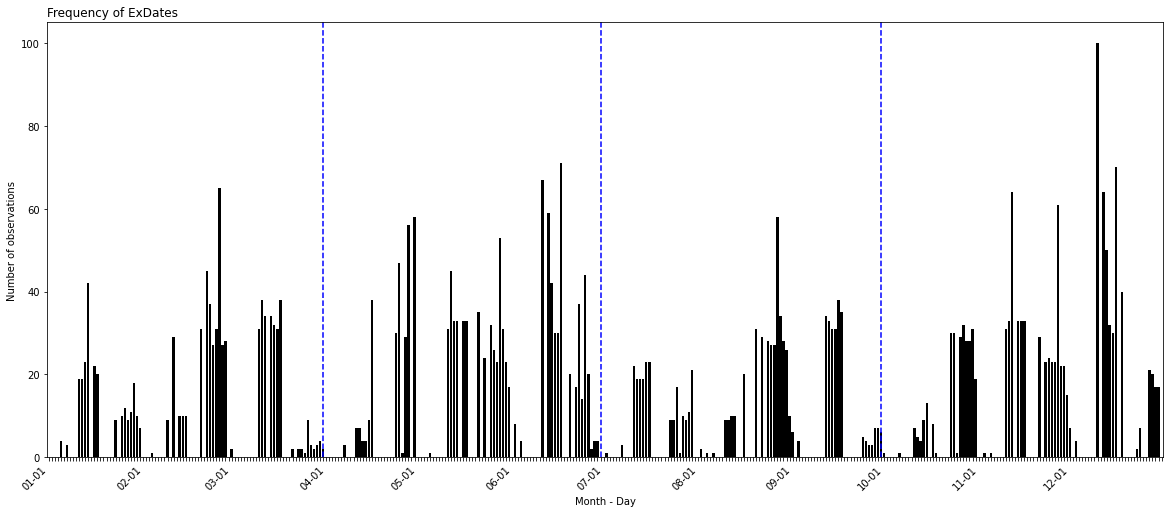

In [6]:
# Inspect the distribution of observations - Ex Date

df_plot = df_dist_dates[['Security_ISIN', 'Dist_Date_Ex']].rename(columns={'Dist_Date_Ex':'Date'}).copy()

# Extract month_day from date and add dummy year
df_plot['Date'] = [str(d) + "_" + str(m) + "_2000" for m,d in zip(df_plot.Date.dt.month, df_plot.Date.dt.day)]

# Transform to datetime
df_plot['Date'] = pd.to_datetime(df_plot['Date'], format="%d_%m_%Y")

# Aggregate by date
df_plot = df_plot.groupby('Date').size().reset_index(name='obs')

# Add possibly missing dates
idx = pd.date_range('2000-01-01', '2000-12-31')
df_plot = pd.DataFrame(data={'Date': idx}).join(df_plot.set_index('Date'), on = 'Date')

# Replace NA
df_plot = df_plot.fillna(0)

dates = list(df_plot.Date.dt.strftime('%m-%d'))

# # # Draw the graph
fig = plt.figure(figsize=(20, 8))

# # # # Cannot use histplot; need column plot
ax = sns.barplot(data=df_plot, x='Date', y='obs', color='black')

# Custom x labels -> display first day of the month?
x_lab = [d.strftime('%m-%d') if d.day == 1 else "" for d in df_plot.Date]
ax.set_xticklabels(labels=x_lab, rotation=45, ha='right')

# Add vertical lines for actual end of quarters
plt.axvline(x = dates.index('03-31'), color='blue', ls='--')
plt.axvline(x = dates.index('06-30'), color='blue', ls='--')
plt.axvline(x = dates.index('09-30'), color='blue', ls='--')

# Add vertical lines for newly assigned end of quarters
# TODO: Do not need to reassign quarters!

plt.title("Frequency of ExDates", loc='left')

plt.xlabel('Month - Day')
plt.ylabel('Number of observations')

plt.savefig('graphics/predict_dist_topdown_frequency_exdates.png')

plt.show()


In [7]:
# Aggregate daily data to quarters
df_temp = df_dist_dates[['Security_ISIN', 'Dist_Date_Ex', 'Dist_Amount']].rename(columns={'Dist_Date_Ex':'Date'}).copy()

df_temp['Year'] = df_temp.Date.dt.year

def transDateToQuarter(month, day):

    # Define cut off date, i.e. how many days after a quarter are still assigned to the last quarter
    cut = 0

    if ((month == 1) & (day > cut)) | (month == 2) | (month == 3) | ((month == 4) & (day <= cut)):
        return(1)
    elif ((month == 4) & (day > cut)) | (month == 5) | (month == 6) | ((month == 7) & (day <= cut)):
        return(2)
    elif ((month == 7) & (day > cut)) | (month == 8) | (month == 9) | ((month == 10) & (day <= cut)):
        return(3)
    else:
        return(4)

df_temp["Q"] = [transDateToQuarter(m, d) for m, d in zip(df_temp.Date.dt.month, df_temp.Date.dt.day)]

# Create year-q combi
df_temp["Y_Q"] = [str(i) + "Q" + str(j) for i,j in zip(df_temp['Year'], df_temp['Q'])]

# Format as datetime(year, quarter)
# pd.to_datetime(df_temp.Y_Q, format = "%YQ%q")
df_temp["Y_Q"] = pd.PeriodIndex(df_temp.Y_Q, freq = 'Q')


# # # Change typ of dist column to numeric
df_temp[df_temp.Dist_Amount == "--"] = "0"
df_temp['Dist_Amount'] = df_temp.Dist_Amount.astype(float)

# # # Group by new column
df_temp = df_temp.groupby(['Security_ISIN', 'Y_Q', 'Year']).agg({'Dist_Amount': 'sum'}).reset_index()

df_temp = df_temp[~(df_temp.Security_ISIN == "0")]

df_temp["Y_Q"] = pd.PeriodIndex(df_temp.Y_Q, freq='Q').to_timestamp()

df_temp.head()


,Security_ISIN,Y_Q,Year,Dist_Amount
0,IE0005042456,2000-07-01,2000,0.0637
1,IE0005042456,2000-10-01,2000,0.0229
2,IE0005042456,2001-01-01,2001,0.0188
3,IE0005042456,2001-04-01,2001,0.1014
4,IE0005042456,2001-07-01,2001,0.0443


In [8]:
# Extend DF by missing quarters. 
# ETF-products that distribute only every second quarter, will not have an observation for every other quarter. 
# Need to fill that with 0s.

# Calculate min and max dates per isin
df_expand = df_temp.groupby(['Security_ISIN']).agg({'Y_Q':['min', 'max']}).reset_index()

# expand dates
df_check_ = pd.DataFrame()

for i, row in df_expand.iterrows():
    # Shift by one day, as this function returns last day in quarter, and function further up returned first day in new quarter
    i_range = pd.date_range(row[('Y_Q', 'min')], row[('Y_Q', 'max')], freq='Q') + timedelta(days=1)
    isin_i = row['Security_ISIN']
    df_range = pd.DataFrame(data={'Y_Q': i_range})
    df_range['Security_ISIN'] = isin_i[0]
    df_check_ = df_check_.append(df_range)

df_temp_exp = (
    df_check_.
    join(df_temp.set_index(['Security_ISIN', 'Y_Q']), on = ['Security_ISIN', 'Y_Q'])
) 

# Fill NA values
df_temp_exp['Year'] = df_temp_exp.Y_Q.dt.year
df_temp_exp = df_temp_exp.fillna(value={'Dist_Amount':0})
df_temp_exp.describe()


,Year,Dist_Amount
count,5444.000000,5444.000000
mean,2014.985672,0.332727
std,4.654021,0.669851
min,2000.000000,0.000000
25%,2011.000000,0.000000
50%,2016.000000,0.082000
75%,2019.000000,0.319850
max,2022.000000,9.740900


## Inspect distribution patterns

Inspect different type of distribution behaviors

* Do we have upward / downward trends?
* Are there outliers; maybe due to high one-time payments
* Is there erratic behavior? Is the distribution even predictable with a top-down approach?

And how does this look like on a quarterly vs yearly perspective? As is and for moving average/sum?

Can we predict on ??? :
* Quarterly
* Yearly
* Moving averages/sum

How to evaluate a good model? RMSE? MAPE?

<Figure size 1440x576 with 0 Axes>

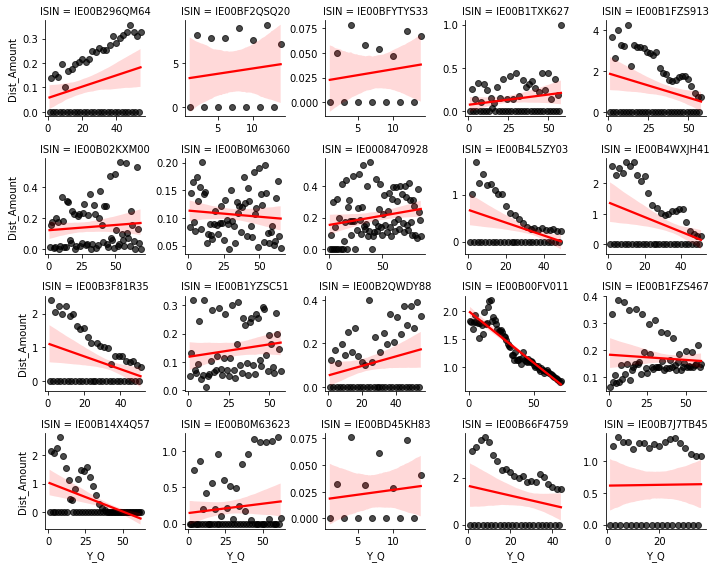

In [9]:
# Find and define different patterns

# Arrange scatter plots by correlation to selected ETF product

import scipy.stats

# Seasonality and somewhat downward trend
# sns.lineplot(data = df_temp[df_temp.Security_ISIN == 'IE0008471009'], x = "Y_Q", y = 'Dist_Amount')

# Discontinued distributions -> paid for several years and then stopped
# No trend at all -> random cloud of data points
# ---> ???


# replace timestampe Y_Q with counter so that poly_fit can work
df_plot = df_temp_exp.copy()
df_plot['Y_Q'] = df_plot.groupby('Security_ISIN').cumcount() + 1

# Filter to securities with at least 3 years of data, i.e. Y_Q > 12
df_plot_filter = df_plot.groupby('Security_ISIN')['Y_Q'].max().reset_index()
df_plot_filter = df_plot_filter[df_plot_filter.Y_Q > 12]
df_plot = df_plot[df_plot.Security_ISIN.isin(df_plot_filter.Security_ISIN)]


# Sort ISINS by highest correlation to benchmark isin
isin_bench = "IE00B296QM64"
isin_list = df_temp.Security_ISIN.unique()
isin_dict = {}

df_bench = df_temp_exp[df_temp_exp.Security_ISIN == isin_bench][['Y_Q', 'Dist_Amount']].rename(columns = {'Dist_Amount': 'Dist_Bench'})


for isin_i in isin_list:

    try:
        df_i = df_temp_exp[df_temp_exp.Security_ISIN == isin_i][['Y_Q', 'Dist_Amount']]

        df_i = df_bench.join(df_i.set_index(['Y_Q']), on = 'Y_Q', how = 'inner')

        isin_dict[isin_i] = [scipy.stats.pearsonr(df_i.Dist_Bench, df_i.Dist_Amount)[0]]
    except:
        print(isin_i)

df_sort = pd.DataFrame.from_dict(isin_dict)
df_sort = pd.DataFrame(df_sort.loc[0,])
df_sort.reset_index(inplace = True)
df_sort.columns = ['Security_ISIN', 'Cor']
df_plot = df_plot.join(df_sort.set_index('Security_ISIN'), on = 'Security_ISIN', how = 'left').sort_values(['Cor', 'Y_Q'], ascending = [False, True])


# # # Draw the graph
fig = plt.figure(figsize=(20, 8))
fig.tight_layout(h_pad=2)

df_plot = df_plot[df_plot.Security_ISIN.isin(isin_list[1::5][:21])]
df_plot = df_plot.rename(columns={'Security_ISIN': 'ISIN'})

g = sns.FacetGrid(df_plot, col="ISIN", col_wrap=5, height=2, sharey=False, sharex=False)
g.map(sns.regplot, "Y_Q", "Dist_Amount", order=1, scatter_kws={"color": "black", "alpha": 0.7}, color = "red")

g.savefig('graphics/predict_dist_topdown_regplot_quarterly.png')


<Figure size 1440x576 with 0 Axes>

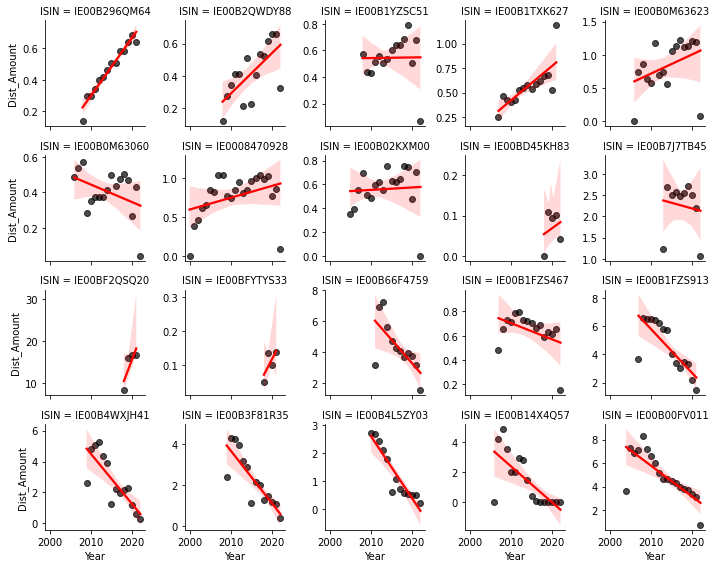

In [10]:
# There are many products which do not distribute every quarter.
# Inspect yearly data

import scipy.stats

# replace timestampe Y_Q with counter so that poly_fit can work
df_plot = df_temp_exp.copy()
df_plot = df_plot.groupby(['Security_ISIN', 'Year']).agg({'Dist_Amount':'sum'}).reset_index()
# df_plot['Y_Q'] = df_plot.groupby('Security_ISIN').cumcount() + 1

# # Filter to securities with at least 3 years of data, i.e. Y_Q > 12
df_plot_filter = df_plot.groupby('Security_ISIN')['Year'].count().reset_index()
df_plot_filter = df_plot_filter[df_plot_filter.Year > 3]
df_plot = df_plot[df_plot.Security_ISIN.isin(df_plot_filter.Security_ISIN)]


# # Sort ISINS by highest correlation to benchmark isin
isin_bench = "IE00B296QM64"
isin_list = df_temp.Security_ISIN.unique()
isin_dict = {}

df_bench = df_temp_exp[df_temp_exp.Security_ISIN == isin_bench][['Year', 'Dist_Amount']].rename(columns = {'Dist_Amount': 'Dist_Bench'})


for isin_i in isin_list:

    try:
        df_i = df_temp_exp[df_temp_exp.Security_ISIN == isin_i][['Year', 'Dist_Amount']]

        df_i = df_bench.join(df_i.set_index(['Year']), on = 'Year', how = 'inner')

        isin_dict[isin_i] = [scipy.stats.pearsonr(df_i.Dist_Bench, df_i.Dist_Amount)[0]]
    except:
        print(isin_i)

df_sort = pd.DataFrame.from_dict(isin_dict)
df_sort = pd.DataFrame(df_sort.loc[0,])
df_sort.reset_index(inplace = True)
df_sort.columns = ['Security_ISIN', 'Cor']
df_plot = df_plot.join(df_sort.set_index('Security_ISIN'), on = 'Security_ISIN', how = 'left').sort_values(['Cor', 'Year'], ascending = [False, True])


# Draw the graph
fig = plt.figure(figsize=(20, 8))
fig.tight_layout(h_pad=2)

df_plot = df_plot[df_plot.Security_ISIN.isin(isin_list[1::5][:21])]
df_plot = df_plot.rename(columns={'Security_ISIN': 'ISIN'})

g = sns.FacetGrid(df_plot, col="ISIN", col_wrap=5, height=2, sharey=False, sharex=True)
g.map(sns.regplot, "Year", "Dist_Amount", order=1, scatter_kws={"color": "black", "alpha": 0.7}, color = "red")

g.savefig('graphics/predict_dist_topdown_regplot_yearly.png')


Prediction on yearly data should be much easier than on quarterly data.

There seem to be some clear upward and downward trends. And not too many zeros.

## Inspect time series properties

Check Partial Autocorrelation, etc.

Check stationarity

Need these checks to determine which models might be appropriate and which features need to go into the model

Work on yearly data!

In [11]:
df_temp_exp_y = df_temp_exp.groupby(['Security_ISIN', 'Year']).agg({'Dist_Amount':'sum'}).reset_index()

In [79]:
# Remove the year 2022 already here. The year is not complete.
df_temp_exp_y = df_temp_exp_y[df_temp_exp_y.Year < 2022]

### Augmented-Dickey-Fuller Test

In [80]:
from statsmodels.tsa.stattools import adfuller

def calc_adfuller(x_):

    x_d = np.diff(x_)

    # Check time series as is
    level_c = adfuller(x_)[1]

    # Check with trend
    level_ct = adfuller(x_, regression="ct")[1]

    # Check first differences
    diff_c = adfuller(x_d)[1]

    # Check first differences with trend
    diff_ct = adfuller(x_d, regression="ct")[1]

    return [level_c, level_ct, diff_c, diff_ct]

# Collect all results
dict_adfuller = {}

for isin_i in df_temp_exp_y.Security_ISIN.unique():

    x_ = df_temp_exp_y[df_temp_exp_y.Security_ISIN == isin_i]['Dist_Amount']

    if (len(x_)) > 8:

        dict_adfuller[isin_i] = calc_adfuller(x_)



df_adfuller = pd.DataFrame.from_dict(dict_adfuller, orient="index", columns=['level_c', 'level_ct', 'diff_c', 'diff_ct'])


<Figure size 1440x576 with 0 Axes>

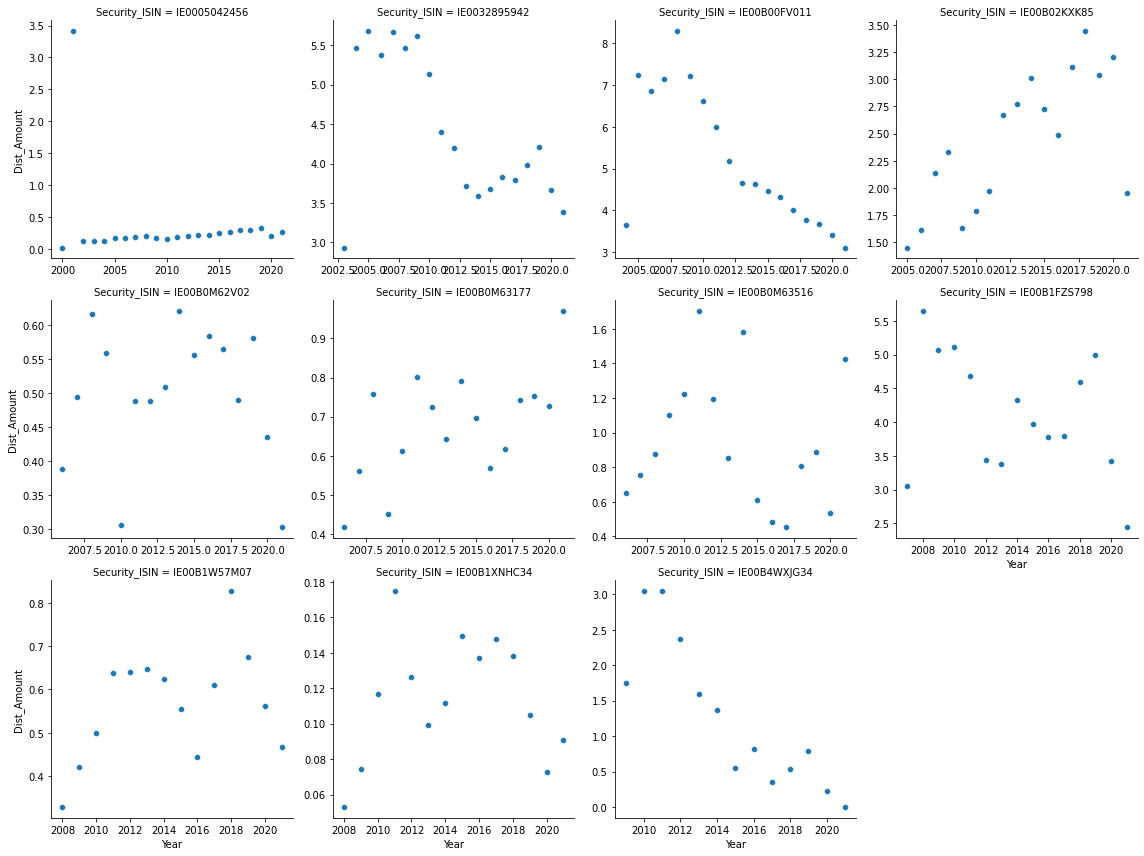

In [81]:
# Find problematic observations, i.e. where none of the adfuller tests rejects the H0

df_adfuller_problems = df_adfuller[(df_adfuller.level_c > 0.05) & (df_adfuller.level_ct > 0.05) & (df_adfuller.diff_c > 0.05) & (df_adfuller.diff_ct > 0.05)]

df_adfuller_plot = df_temp_exp_y.copy()

df_adfuller_plot = df_adfuller_plot[df_adfuller_plot.Security_ISIN.isin(df_adfuller_problems.index)]

fig = plt.figure(figsize=(20, 8))

g = sns.FacetGrid(df_adfuller_plot, col="Security_ISIN", col_wrap=4, height=4, sharey=False, sharex=False)
g.map(sns.scatterplot, "Year", "Dist_Amount")

# It looks like changes in the distribution policy. Seasonal distrbutions in the beginning, and then more evenly distributed over quarters
# And also not linear trends. Trend follows some poly-fit.

Problems arise with outliers.

For once, those could be one-time payments.

Otherwise, extreme-events like Covid19 and the introduced ban on dividend payments on certain industries, destroy normal patterns.

### (Partial) Autocorrelation

Check how many lags could be relevant for our time series

C:\Users\phili\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


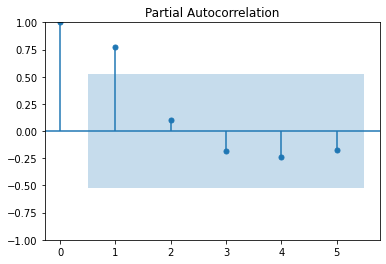

In [82]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import pacf

isin_i = "IE00B296QM64"

x_ = df_temp_exp_y[df_temp_exp_y.Security_ISIN == isin_i]['Dist_Amount']

plot_pacf(x_, lags=5, alpha=0.05)
plt.savefig('graphics/predict_dist_topdown_PACF_sample.png')
plt.show()

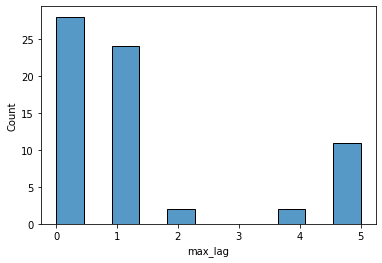

In [83]:
# Calculate max lags for all ETF products
def calc_max_lag(x_):
    # Calculate partial autocorrelation function
    pacf_ = pacf(x_, nlags=5, alpha=0.05)

    # Collect results
    pacf_ = np.insert(pacf_[1], 0, np.transpose(pacf_[0]), axis=1)

    # Check which values with the same calculations performed in plot_pacf
    pacf_check = (pacf_[:,0] > (pacf_[:,0] - pacf_[:,1])) | (pacf_[:,0] < (pacf_[:,0] - pacf_[:,2]))

    return np.max(np.where(pacf_check))


# Collect all results
dict_max_lag = {}

for isin_i in df_temp_exp_y.Security_ISIN.unique():

    x_ = df_temp_exp_y[df_temp_exp_y.Security_ISIN == isin_i]['Dist_Amount']

    if (len(x_)) > 12:

        dict_max_lag[isin_i] = calc_max_lag(x_)



df_max_lag = pd.DataFrame.from_dict(dict_max_lag, orient="index", columns=['max_lag'])



# Distribution of max lag
sns.histplot(data=df_max_lag, x='max_lag')
plt.savefig('graphics/predict_dist_topdown_PACF_distribution.png')

There seems to be mostly 1 or 2 lags relevant! That is good news!

C:\Users\phili\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
C:\Users\phili\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
C:\Users\phili\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by sett

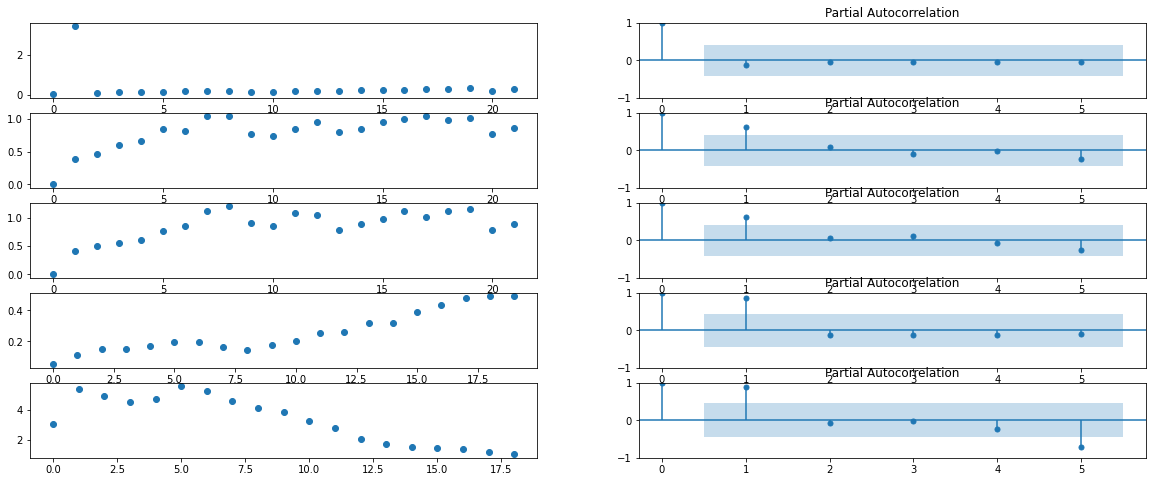

In [84]:
# Inspect where lots of lags are relevant
df_max_lag.sort_values('max_lag', ascending=False)

# Create subplots for: scatter + pacf + other
fig, axs = plt.subplots(5, 2, figsize=(20, 8))

for i in range(5):

    # isin_i = "IE00B14X4S71"
    isin_i = df_max_lag.reset_index().iloc[i,]['index']

    x_ = df_temp_exp_y[df_temp_exp_y.Security_ISIN == isin_i]['Dist_Amount']

    # Plot all scatter and pacf
    axs[i,0].scatter(x=[*range(len(x_))], y=x_)

    plot_pacf(x_, lags=5, alpha=0.05, ax=axs[i,1])

plt.savefig('graphics/predict_dist_topdown_PACF_sample_5.png')
plt.show()

## Setup testing framework

Need framework to quickly assess the quality of a forecast model.

Need to check:
* Backtesting results
* Train vs Test performance
* Out-of-sample performace -> how does the model behave for the next N Quarters. Does it get negative? Does it explode?

Plan:

* So, for each ETF-product, we need to split the data into test/train
* Then, the backtesting will be an in-sample check for the training periods and a first out-of-sample test for the testing periods
* Then, we will let the model run for another N quarters to observe the model behavior in totally unknown periods

Problems:

* Analysis of several time series at once. Usual analysis of time series only perfomred on one group. Need to find approach to estimate for all ETF-products at once!
* Different time horizones -> Need to split data into even buckets?

In [114]:
# Feature selection

df_model = df_temp_exp_y.copy()

# TODO: Would difflogs make sense?

# Replace 0 values with 0.0001
df_model.loc[df_model.Dist_Amount == 0, 'Dist_Amount'] = 0.0001

# Transform to log
# PL 02.05.2022 -> do not!
# df_model['Dist_Amount'] = np.log(df_model['Dist_Amount'])

# Y = Dist_Amount
# X = Lag Levels + Lag Diffs

def calc_features(df_model, calc_levels = True):

    # Sort dataframe to make sure the order is correct before applying shift()
    df_model = df_model.sort_values(['Security_ISIN', 'Year'], ascending=[True, True])

    if calc_levels:
        # Add lagged levels
        df_model['Dist_L1'] = df_model.groupby(['Security_ISIN'])['Dist_Amount'].shift()
        df_model['Dist_L2'] = df_model.groupby(['Security_ISIN'])['Dist_Amount'].shift(2)
        df_model['Dist_L3'] = df_model.groupby(['Security_ISIN'])['Dist_Amount'].shift(3)
        df_model['Dist_L4'] = df_model.groupby(['Security_ISIN'])['Dist_Amount'].shift(4)

        # Add average of levels - mean reversion
        df_model['Dist_Avg_L1_L4'] = (df_model['Dist_L1'] + df_model['Dist_L2'] + df_model['Dist_L3'] + df_model['Dist_L4']) / 4
        df_model['Dist_Avg_L1_L3'] = (df_model['Dist_L1'] + df_model['Dist_L2'] + df_model['Dist_L3']) / 3
        df_model['Dist_Avg_L1_L2'] = (df_model['Dist_L1'] + df_model['Dist_L2']) / 2

    # Calculate differences
    df_model['DDist_L1_L2'] = df_model['Dist_L1'] - df_model['Dist_L2']
    df_model['DDist_L1_L3'] = df_model['Dist_L1'] - df_model['Dist_L3']
    df_model['DDist_L1_L4'] = df_model['Dist_L1'] - df_model['Dist_L4']

    df_model['DDist_L2_L3'] = df_model['Dist_L2'] - df_model['Dist_L3']
    df_model['DDist_L2_L4'] = df_model['Dist_L2'] - df_model['Dist_L4']

    df_model['DDist_L3_L4'] = df_model['Dist_L3'] - df_model['Dist_L4']

    # Calculate relative differences
    df_model['DDist_Rel_L1_L2'] = df_model['DDist_L1_L2'] / df_model['Dist_L2']
    df_model['DDist_Rel_L1_L3'] = df_model['DDist_L1_L3'] / df_model['Dist_L3']
    df_model['DDist_Rel_L1_L4'] = df_model['DDist_L1_L4'] / df_model['Dist_L4']

    df_model['DDist_Rel_L2_L3'] = df_model['DDist_L2_L3'] / df_model['Dist_L3']
    df_model['DDist_Rel_L2_L4'] = df_model['DDist_L2_L4'] / df_model['Dist_L4']

    df_model['DDist_Rel_L3_L4'] = df_model['DDist_L3_L4'] / df_model['Dist_L4']

    # Return
    return df_model

df_model = calc_features(df_model)

# Remove NA values - obs with not enough lagged data
df_model = df_model.dropna()

# Reset index
df_model.reset_index(drop=True, inplace=True)

<AxesSubplot:xlabel='Dist_Amount', ylabel='Dist_L1'>

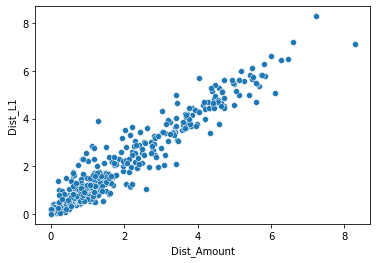

In [115]:
# Inspect Y and Y_-1 -> linear relationship
# NO exponential growth -> NO LOG TRANSFORM!!
# BUT! maybe difflogs? or diffs?
sns.scatterplot(data=df_model, x='Dist_Amount', y='Dist_L1')

## Try different models

Compare different models for their ability to predict distributions

Test:
* Base Case: T = (T-1) -> simple lagged model
* Linear Regression
* Random Forest Regressor
* SARIMA


In general, we might have a problem with a lot of 0s.
Some funds distribute quarterly, some only every second and some only yearly.
And some will change their distributions intervals over time.


Do we need to create a separate model for each distribution interval?
* Quarterly distributions
* Semi-Annual distributions
* Annaul distributions


In [89]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error

## Define Train and test data sets

For now, define a single split. Later on, move this split year to increase model stability

In [116]:
train = df_model[df_model.Year < 2018].set_index(['Security_ISIN', 'Year'])#, axis = 1)
test = df_model[df_model.Year >= 2018].set_index(['Security_ISIN', 'Year'])#, axis = 1)

X_train = train.drop(['Dist_Amount'], axis = 1)
X_test = test.drop(['Dist_Amount'], axis = 1)

Y_train = train['Dist_Amount']
Y_test = test['Dist_Amount']

## Define Models

### Baseline

In [117]:
# TODO: Define base line model: y_t = y_(t-1)
# score_base = mean_absolute_percentage_error(Y_test, test["Dist_L1"])
score_base = mean_absolute_error(Y_test, test["Dist_L1"])
score_base

0.20048731988472623

### Random Forest

In [118]:
# First, simple model
model_rf = RandomForestRegressor(n_estimators=10, criterion='absolute_error', n_jobs=-1, random_state=0)
model_rf.fit(X_train, Y_train)

p = model_rf.predict(X_test)

score_rf_first_guess = mean_absolute_error(Y_test, p)
score_rf_first_guess


0.20546095100864553

In [23]:
# # GridSearch optimized model
# model_rf = RandomForestRegressor(max_depth=16, max_features='sqrt', n_estimators=20, n_jobs=-1, random_state=0)
# model_rf.fit(X_train, Y_train)

# p = model_rf.predict(X_test)

# error = mean_absolute_percentage_error(Y_test, p)
# error

In [119]:
train_cv = df_model.drop(['Security_ISIN', 'Year'], axis = 1)
test_cv = df_model.drop(['Security_ISIN', 'Year'], axis = 1)

X_train_cv = train_cv.drop(['Dist_Amount'], axis = 1)
X_test_cv = test_cv.drop(['Dist_Amount'], axis = 1)

Y_train_cv = train_cv['Dist_Amount']
Y_test_cv = test_cv['Dist_Amount']

In [121]:
# Custom gridsearh cv for hyperparamter tuning

# Split data either by Security_ISIN or by Year

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# mean_squared_error_score = make_scorer(mean_squared_error)
# mean_absolute_percentage_error_score = make_scorer(mean_absolute_percentage_error)
mean_absolute_error_score = make_scorer(mean_absolute_error)

model_rf_temp = RandomForestRegressor(n_jobs=-1, random_state=0)

# TODO: Make test windows always same size? 2 years? -> Expanding window
# TODO: OR check for moving window: train and test window always same size: 4 years train + 2 years test


CViterator = []
# i = last year in sample
# for i in range(2010, 2019):
#     # trainIndices = df_model[ df_model.Year < i ].index.values.astype(int)
#     # testIndices =  df_model[ df_model.Year >= i ].index.values.astype(int)

#     # Moving window
#     trainIndices = df_model[ df_model.Year.between(i-5, i-2)].index.values.astype(int)
#     testIndices =  df_model[ df_model.Year.between(i-1, i)].index.values.astype(int)
#     CViterator.append( (trainIndices, testIndices) )

# TODO: it seems like the windows are too small! The simple rf model trained on (x, 2018) outperforms the CV results without any problems.
# Or is it just a very lucky perfect fit for the test data?

# Single CV split
trainIndices = df_model[ df_model.Year < 2018].index.values.astype(int)
testIndices =  df_model[ df_model.Year >= 2018].index.values.astype(int)
CViterator.append( (trainIndices, testIndices) )


param_search = { 
    'criterion': ['absolute_error'], # 'squared_error', 
    # 'n_estimators': [5, 7, 10], #, 500, 1000
    # 'max_features': ['auto', 'sqrt', 'log2'], # , 5, 10
    # 'max_depth' : [3, 5, 10, 15, 20, 25],
    # Leaf - samples - smoothing

    # Increases in sample - overfit - test error increases with these parameters
    # 'min_samples_split': [2, 5, 10, 15], # 5, 10,
    # 'min_samples_leaf': [20, 25, 30]
}

gsearch = GridSearchCV(estimator=model_rf_temp, cv=CViterator, param_grid=param_search, scoring=mean_absolute_error_score)
gsearch.fit(X_train_cv, Y_train_cv)
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_

In [26]:
best_model

RandomForestRegressor(criterion='absolute_error', max_depth=3, n_estimators=5,
                      n_jobs=-1, random_state=0)

In [123]:
# GridSearch optimized model
model_rf_optim = gsearch.best_estimator_

model_rf_optim.fit(X_train, Y_train)

p = model_rf_optim.predict(X_test)

score_cv_optim = mean_absolute_error(Y_test, p)
score_cv_optim

0.19886253314121033

In [124]:
# Seems like lagged level values are most important! Esp. first lagged value!
top_features = pd.DataFrame({n:i for i, n in zip(gsearch.best_estimator_.feature_importances_, gsearch.best_estimator_.feature_names_in_)}, index=[1]).melt().sort_values("value", ascending=False)
top_features[:5]

,variable,value
0,Dist_L1,0.543684
6,Dist_Avg_L1_L2,0.162426
4,Dist_Avg_L1_L4,0.075058
5,Dist_Avg_L1_L3,0.065463
16,DDist_Rel_L2_L3,0.012908


### Linear model (Ridge, Lasso, ElasticNet)

In [125]:
# Check how models would be estimated in a brute force feature selection approach
from itertools import combinations

n_feat_comb = combinations(X_train.columns, 5)
len(list(n_feat_comb))

11628

In [126]:
# TODO: Reduce number of features: https://towardsdatascience.com/19-hidden-sklearn-features-you-were-supposed-to-learn-the-hard-way-5293e6ff149
# https://scikit-learn.org/stable/modules/feature_selection.html
# -> OR! brute force all combinations, store and sort select model with lowest mean absolute error!!
# HOW MANY COMBINATIONS WOULD THAT BE? We have 16 features 

# TODO: Drop Standardscaler and just remove extreme obs which causes problems -> change of dist by 8.000% is a bit much.
# TODO: Estimate difflogs! Can we include the transformation inside the pipe? -> WILL DROP 1 obs / security !!!

from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Ridge, Lasso, ElasticNet

# Work with pipe here! interactions make sense for linear (parametric) models only.
# A random forest implicitly models interactions effect by its sequential use of variables

# REf: https://stackoverflow.com/questions/69443936/sklearn-pipeline-with-standardscaler-polynomialfeatures-and-regression

# define the pipeline
model_linear = Pipeline(steps=[
    ('scaler', StandardScaler()),
    # Squared values do not make sense
    # Intercept not helpful as model still estimated at levels
    ('preprocessor', PolynomialFeatures(degree=1, interaction_only=True, include_bias=False)),
    # TODO: Select best features
    # ('feature_selection', SelectFromModel(Lasso())),
    
    # Model
    ('estimator', Ridge(random_state=0))
    # ('estimator', Lasso(random_state=0))
    # ('estimator', ElasticNet(random_state=0))
])

# fit the pipeline
model_linear.fit(X_train, Y_train)

# generate the model predictions
p = model_linear.predict(X_test)

# scoring
score_linear_first_guess = mean_absolute_error(Y_test, p)
score_linear_first_guess

0.19804771642021854

In [466]:
# Ridge Regresssion

# model_ridge = Ridge(random_state=0)
# model_ridge.fit(X_train, Y_train)

# p = model_ridge.predict(X_test)

# score_ridge_first_guess = mean_absolute_error(Y_test, p)
# score_ridge_first_guess


0.19802966857039017

In [127]:
CViterator = []
# Single CV split
trainIndices = df_model[ df_model.Year < 2018].index.values.astype(int)
testIndices =  df_model[ df_model.Year >= 2018].index.values.astype(int)
CViterator.append( (trainIndices, testIndices) )


param_search = { 
    # Higher values = overfit
    'estimator__alpha': [1, 10, 50, 100]#, #, 500, 1000
    # 'solver': ['auto', ‘svd’, ‘cholesky’, ‘lsqr’, ‘sparse_cg’, ‘sag’, ‘saga’, ‘lbfgs’]

}

gsearch = GridSearchCV(estimator=model_linear, cv=CViterator, param_grid=param_search, scoring=mean_absolute_error_score)
gsearch.fit(X_train_cv, Y_train_cv)
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_
best_model

Pipeline(steps=[('scaler', StandardScaler()),
                ('preprocessor',
                 PolynomialFeatures(degree=1, include_bias=False,
                                    interaction_only=True)),
                ('estimator', Ridge(alpha=100, random_state=0))])

In [128]:
# GridSearch optimized model
model_linear_optim = gsearch.best_estimator_

model_linear_optim.fit(X_train, Y_train)

p = model_linear_optim.predict(X_test)

score_linear_optim = mean_absolute_error(Y_test, p)
score_linear_optim

0.20068669544585802

## Comparison of model performance

In [129]:
# Compare scores of different models

# Simple lagged model
print("Baseline: {:2f}" .format(score_base))

# Random Forest first guess
print("RF Guess: {:2f}" .format(score_rf_first_guess))

# Random Forest GridSearchCV
print("RF Optim: {:2f}" .format(score_cv_optim))

# Ridge first guess
print("Linear Guess: {:2f}" .format(score_linear_first_guess))

# Ridge GridSearchCV
print("Linear Optim: {:2f}" .format(score_linear_optim))


Baseline: 0.200487
RF Guess: 0.205461
RF Optim: 0.198863
Linear Guess: 0.198048
Linear Optim: 0.200687


In [130]:
# Inspect potential for model optimiziation
# Where does the model have the most problems?

# Identify largest errors in test
Y_check = gsearch.best_estimator_.predict(X_test)

mae_check = abs(Y_test - Y_check) #/ abs(Y_test)

mae_check.describe()

# Year 2022 seems problematic. What happend for these securities?
# They did not receive all distributions yet! Year 2022 dropped as the year is not complete yet.
idx_err = np.where(mae_check > 1.25)

X_test.iloc[idx_err]



Dist_L1  Dist_L2  Dist_L3  Dist_L4  Dist_Avg_L1_L4  \
Security_ISIN Year                                                       
IE00B14X4S71  2019   2.0593   1.2676   0.9790   0.6788        1.246175   
              2021   2.3084   3.0729   2.0593   1.2676        2.177050   

                    Dist_Avg_L1_L3  Dist_Avg_L1_L2  DDist_L1_L2  DDist_L1_L3  \
Security_ISIN Year                                                             
IE00B14X4S71  2019          1.4353         1.66345       0.7917       1.0803   
              2021          2.4802         2.69065      -0.7645       0.2491   

                    DDist_L1_L4  DDist_L2_L3  DDist_L2_L4  DDist_L3_L4  \
Security_ISIN Year                                                       
IE00B14X4S71  2019       1.3805       0.2886       0.5888       0.3002   
              2021       1.0408       1.0136       1.8053       0.7917   

                    DDist_Rel_L1_L2  DDist_Rel_L1_L3  DDist_Rel_L1_L4  \
Security_ISIN Year                                                      
IE00B14X4S71  2019         0.624566         1.103473         2.033736   
              2021        -0.248788         0.120963         0.821079   

                    DDist_Rel_L2_L3  DDist_Rel_L2_L4  DDist_Rel_L3_L4  
Security_ISIN Year                                                     
IE00B14X4S71  2019         0.294791         0.867413         0.442251  
              2021         0.492206         1.424187         0.624566

In [131]:
# Copy
df_temp = X_test.copy()
df_temp['Y_check'] = Y_check
df_temp = df_temp[['Y_check']]

<AxesSubplot:xlabel='Year', ylabel='Dist_Amount'>

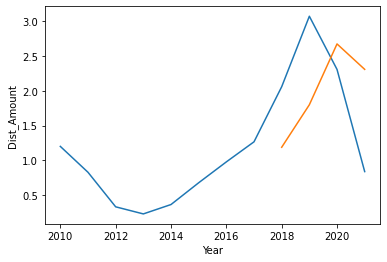

In [132]:
# Delayed reponse. What is wrong in 2019?
df_plot = (
    df_model
    .query('Security_ISIN=="IE00B14X4S71"')
    .join(df_temp, on=['Security_ISIN', 'Year'])
    [['Security_ISIN', 'Year', 'Dist_Amount', 'Y_check']]
)

sns.lineplot(data=df_plot, x='Year', y='Dist_Amount')
sns.lineplot(data=df_plot, x='Year', y='Y_check')

<Figure size 1440x720 with 0 Axes>

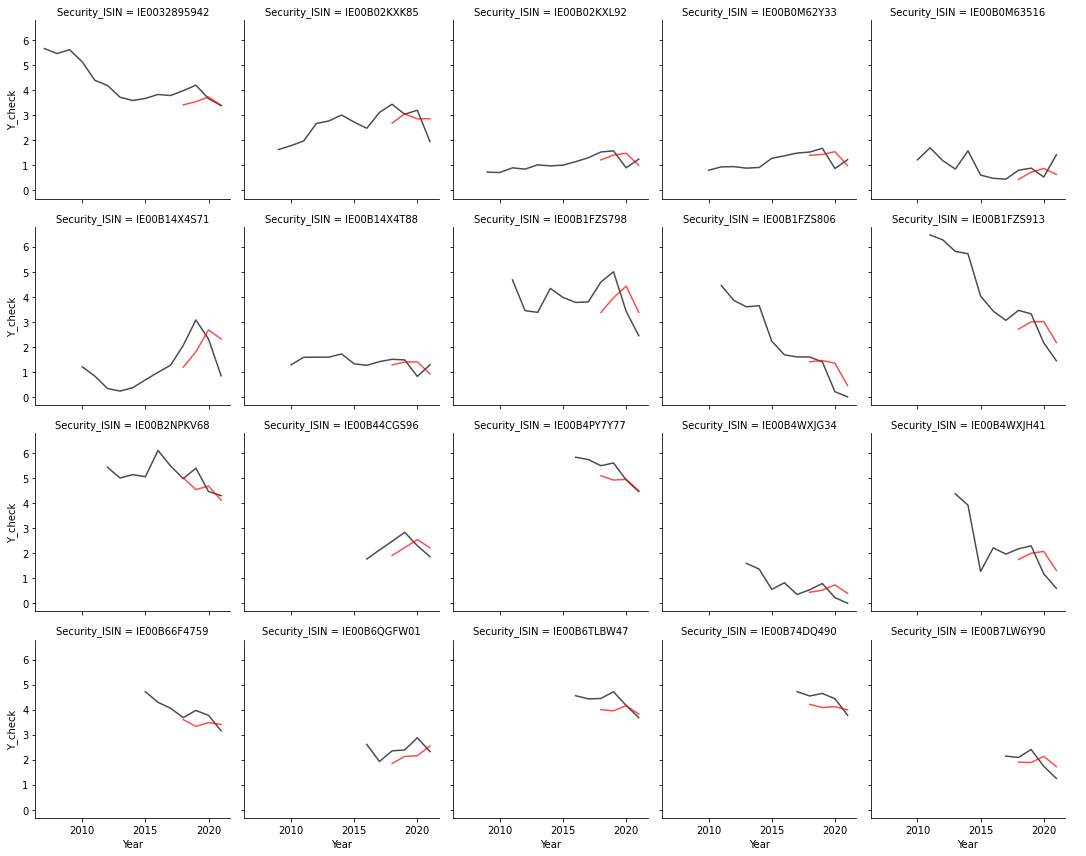

In [133]:
# Inspect 10 worst performing securities
isin_check = mae_check.groupby('Security_ISIN').agg({'mean'}).sort_values('mean', ascending=False).head(20)
isin_check = isin_check.reset_index()
df_plot = (
    df_model.loc[df_model.Security_ISIN.isin(isin_check.Security_ISIN)]
    .join(df_temp, on=['Security_ISIN', 'Year'])
    [['Security_ISIN', 'Year', 'Dist_Amount', 'Y_check']]
)

df_plot.head()

fig = plt.figure(figsize=(20,10))

g = sns.FacetGrid(df_plot, col='Security_ISIN', sharex=True, col_wrap=5)
g.map(sns.lineplot, "Year", "Dist_Amount", alpha=.7, color='black')
g.map(sns.lineplot, "Year", "Y_check", alpha=.7, color='red')
g.add_legend()

In [166]:
# MAPE vs Y_test
# sns.scatterplot(x=Y_test, y=mape_check)

<Figure size 1440x720 with 0 Axes>

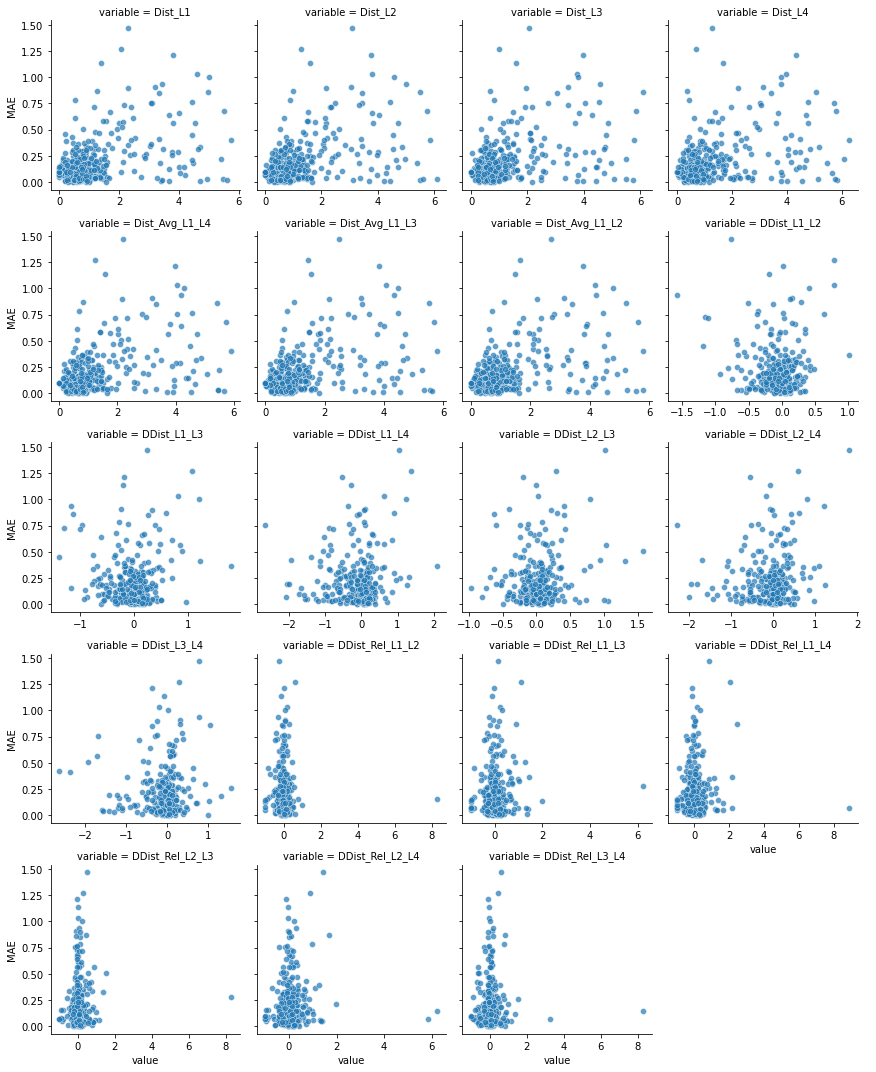

In [134]:
# MAE vs all features in X_test

df_plot = test.copy()
df_plot['MAE'] = mae_check
df_plot = df_plot.drop('Dist_Amount', axis = 1)
df_plot = df_plot.melt(id_vars='MAE')

fig = plt.figure(figsize=(20,10))

g = sns.FacetGrid(df_plot, col='variable', sharex=False, col_wrap=4)
g.map(sns.scatterplot, "value", "MAE", alpha=.7)
g.add_legend()


## Compare quality of forecast models over different time horizons

Model trained to work for 1 year prediction. Test up to 5 / 10 year predictions!

In [135]:
# Check performance of basline vs other models for different forecast horizons!
# -> look up to 5/10 years into the future and calculate errors!

# TODO: Create function for calculating features based on predictions!
# TODO: how to implement the baseline model?


# Create model class for baseline model
class model_baseline:
    def __init__(self):
        self.name="baseline"

    def predict(self, X_):
        return X_['Dist_L1']

model_base = model_baseline()
        
# model_base.predict(X_)




In [136]:
# Visually inspect forecast quality!!!

def predict_mult_periods(model, year_start, year_end, n_periods):

    df_pred = df_model.copy()

    df_pred['Year_Base'] = df_pred['Year']

    for year_base_i in range(year_start, year_end + 1):

        # Predict starting in year 2018 for n years
        df_pred_i = df_pred[df_pred.Year_Base == year_base_i].copy()

        for year_pred_i in range(year_base_i + 1, year_base_i + n_periods):

            # Extract base (previous) year data
            df_pred_i_add = df_pred_i.loc[df_pred_i.Year == year_pred_i - 1].copy()

            # Predict for the current year
            X_ = df_pred_i_add.drop(['Security_ISIN', 'Year', 'Year_Base', 'Dist_Amount'], axis=1)

            # pred_i = best_model.predict(X_)
            pred_i = model.predict(X_)

            # Enter year of prediction
            df_pred_i_add['Year'] = year_pred_i

            # # Copy level values -> information before base_year is missing!
            df_pred_i_add['Dist_L4'] = df_pred_i_add['Dist_L3']
            df_pred_i_add['Dist_L3'] = df_pred_i_add['Dist_L2']
            df_pred_i_add['Dist_L2'] = df_pred_i_add['Dist_L1']
            df_pred_i_add['Dist_L1'] = df_pred_i_add['Dist_Amount']

            # Enter prediction value AFTER infering L1 value!
            df_pred_i_add['Dist_Amount'] = pred_i

            # Add current prediction to base_year collection
            df_pred_i = df_pred_i.append(df_pred_i_add)

            # Recalculate feature columns
            df_pred_i = calc_features(df_pred_i, calc_levels=False)

        df_pred = df_pred.append(df_pred_i[df_pred_i.Year != df_pred_i.Year_Base])

    return df_pred

In [137]:
# Predict for different models

year_start, year_end, n_periods = 2010, 2021, 6

df_pred_base = predict_mult_periods(model_base, year_start, year_end, n_periods)

df_pred_rf = predict_mult_periods(model_rf, year_start, year_end, n_periods)

df_pred_rf_optim = predict_mult_periods(model_rf_optim, year_start, year_end, n_periods)

df_pred_linear = predict_mult_periods(model_linear, year_start, year_end, n_periods)

df_pred_linear_optim = predict_mult_periods(model_linear_optim, year_start, year_end, n_periods)

In [148]:
# Calculate error over predictions periods -> n-years ahead!

def calc_pred_errors(df_pred, name):

    # Select forecasts
    df_temp = (
        df_pred[df_pred.Year != df_pred.Year_Base]
        .rename(columns={'Dist_Amount':'Dist_Pred'})
        # Calculate number of years predicted
        .assign(n_ = lambda x: x.Year - x.Year_Base)
        # Select relevant columns
        [['Security_ISIN', 'Year', 'Dist_Pred', 'n_']]
    )

    # Add actual values
    df_temp = df_temp.join(df_model[['Security_ISIN', 'Year', 'Dist_Amount']].set_index(['Security_ISIN', 'Year']), on=['Security_ISIN', 'Year'])

    # Drop NA values -> out of sample forecast
    df_temp.dropna(inplace=True)

    # Calculate Absolute difference
    df_temp = df_temp.assign(abs_diff = lambda x: abs(x.Dist_Pred - x.Dist_Amount))

    # Calculate average absolute difference per n_
    # df_temp = df_temp.groupby('n_').agg({'abs_diff':['mean', 'size']})

    df_temp['name'] = name

    return df_temp

# df_pred_base[df_pred_base.Year == 2017][['Security_ISIN', 'Year', 'Dist_Amount']].sort_values('Security_ISIN')

In [149]:
# Calculate errors for each model
df_pred_err_base = calc_pred_errors(df_pred_base, "base")
df_pred_err_rf = calc_pred_errors(df_pred_rf, "rf")
df_pred_err_rf_optim = calc_pred_errors(df_pred_rf_optim, "rf_optim")
df_pred_err_linear = calc_pred_errors(df_pred_linear, "linear")
df_pred_err_linear_optim = calc_pred_errors(df_pred_linear_optim, "linear_optim")

df_pred_err = (
    df_pred_err_base
    .append(df_pred_err_rf)
    .append(df_pred_err_rf_optim)
    .append(df_pred_err_linear)
    .append(df_pred_err_linear_optim)
)

df_pred_err.columns = df_pred_err.columns.to_series().apply(''.join)

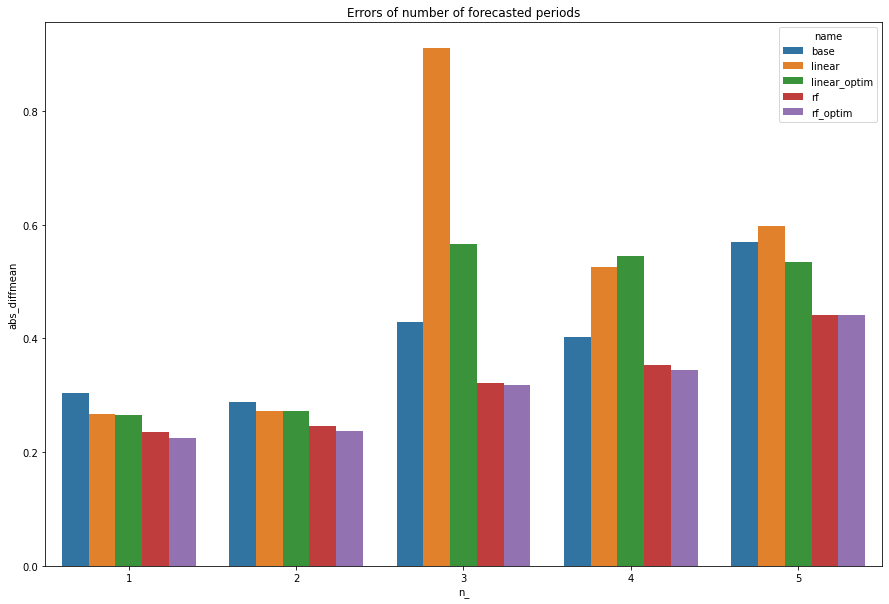

In [195]:
# Visualize errors
fig = plt.figure(figsize=(15,10))

df_plot = df_pred_err.groupby(['name', 'n_']).agg({'abs_diff':['mean', 'size']}).reset_index()
df_plot.columns = df_plot.columns.to_series().apply(''.join)

sns.barplot(data=df_plot, x='n_', y='abs_diffmean', hue='name')

plt.title('Errors of number of forecasted periods')

plt.savefig('graphics/predict_dist_topdown_compare_models.png')

In [394]:
# Make absolutely sure that no values beyond Year_Base are used for the prediction!!!
# df_pred[(df_pred.Security_ISIN == "IE00B1FZS244")&(df_pred.Year_Base==2021)]

,Security_ISIN,Year,Dist_Amount,Dist_L1,Dist_L2,Dist_L3,Dist_L4,DDist_L1_L2,DDist_L1_L3,DDist_L1_L4,DDist_L2_L3,DDist_L2_L4,DDist_L3_L4,Year_Base
423,IE00B1FZS244,2021,-0.201260,-0.164050,-0.135934,-0.098275,-0.179725,-0.028115,-0.065775,0.015675,-0.037660,0.043791,0.043791,2021
423,IE00B1FZS244,2022,-0.179954,-0.201260,-0.164050,-0.135934,-0.098275,-0.037210,-0.065325,-0.102985,-0.028115,-0.065775,-0.065775,2021
423,IE00B1FZS244,2023,-1.152489,-0.179954,-0.201260,-0.164050,-0.135934,0.021306,-0.015904,-0.044019,-0.037210,-0.065325,-0.065325,2021
423,IE00B1FZS244,2024,-0.220819,-1.152489,-0.179954,-0.201260,-0.164050,-0.972535,-0.951229,-0.988439,0.021306,-0.015904,-0.015904,2021
423,IE00B1FZS244,2025,-1.445752,-0.220819,-1.152489,-0.179954,-0.201260,0.931670,-0.040865,-0.019559,-0.972535,-0.951229,-0.951229,2021


In [421]:
# # Calculate predicted and actual distributions over 1, 2, 3, 4, 5 years
# # Find largest differences !!!
# # Also look at different starting dates

# df_pred_check = df_pred.copy()

# df_pred_check['N_Years_Ahead'] = df_pred_check['Year'] - df_pred_check['Year_Base']

# # Filter to predictions only
# df_pred_check = df_pred_check[df_pred_check.N_Years_Ahead != 0]

# # Select relevant columns
# df_pred_check = df_pred_check[['Security_ISIN', 'Year', 'N_Years_Ahead', 'Dist_Amount']].rename(columns={'Dist_Amount': 'Pred_Amount'})

# # Add actual distributions
# df_pred_check = df_pred_check.join(df_model[['Security_ISIN', 'Year', 'Dist_Amount']].set_index(['Security_ISIN', 'Year']), on=['Security_ISIN', 'Year'], how='left')

# # Drop NAs - meaning, there is no information available!
# df_pred_check.dropna(inplace=True)

# # Calculate absolute error
# df_pred_check['Abs_Error'] = abs(df_pred_check['Pred_Amount'] - df_pred_check['Dist_Amount'])
# df_pred_check['Abs_Perc_Error'] = abs(df_pred_check['Pred_Amount'] - df_pred_check['Dist_Amount']) / df_pred_check['Pred_Amount']

# df_pred_check.head()

# # Over all securities, calculate max, min, avg, median of absolute error
# df_pred_check.groupby(['N_Years_Ahead']).agg({'Abs_Error': 'mean', 'Abs_Perc_Error': 'mean'})
# # Error increase with the number of forecasted periods -> That's as expected :)

# # Reverse log transform # -> log transform disabled
# # df_pred['Dist_Amount'] = np.exp(df_pred['Dist_Amount'])



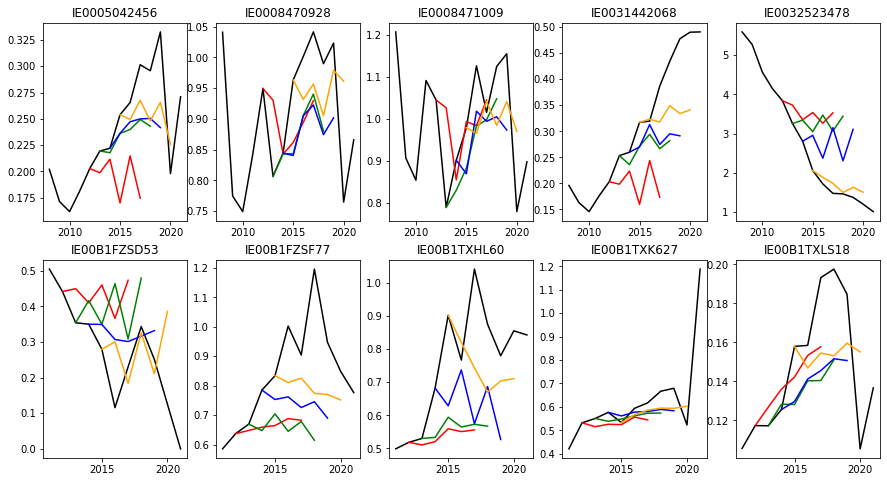

In [190]:
# Visualize with line plot

import matplotlib.pyplot as plt
import math

df_plot = df_pred_rf_optim.copy()

# Determine first year_base for predictions
min_year_base = 2012

# Select top 5 and bottom 5
df_err_by_isin = df_pred_err[df_pred_err.name == 'rf_optim'].groupby('Security_ISIN').agg({'abs_diff':'sum'}).reset_index()

isin_min_year_base = df_pred_rf_optim.groupby('Security_ISIN').agg({'Year_Base':'min'}).query('Year_Base < 2012').reset_index()

df_err_by_isin = df_err_by_isin[df_err_by_isin.Security_ISIN.isin(isin_min_year_base.Security_ISIN)]

isin_list = df_err_by_isin[:5]['Security_ISIN']
isin_list = isin_list.append(df_err_by_isin['Security_ISIN'].tail(5))

# Plot
fig, ax = plt.subplots(2, 5, figsize=(15, 8))

colors = ['red', 'green', 'blue', 'orange', 'purple']

# Create tuples for plot locations
ax_loc = []
for r in range(2):
    for c in range(5):
        ax_loc.append((r, c))

for i_, isin_i in enumerate(isin_list): #[:25]):

    # isin_i = "IE00B296QM64"
    df_plot_i = df_plot[df_plot.Security_ISIN == isin_i].copy()

    df_plot_base = df_plot_i[df_plot_i.Year == df_plot_i.Year_Base].copy()

    # Reduce time horizon
    df_plot_base = df_plot_base[df_plot_base.Year >= (min_year_base - 4)]

    ax_x, ax_y = ax_loc[i_]

    ax[ax_x,ax_y].plot(df_plot_base['Year'], df_plot_base['Dist_Amount'], color='black')

    for i__, year_base_i in enumerate(range(min_year_base, min_year_base + 4)):
        df_plot_i_ = df_plot_i[df_plot_i.Year_Base == year_base_i]
        ax[ax_x,ax_y].plot(df_plot_i_['Year'], df_plot_i_['Dist_Amount'], color=colors[i__])

    ax[ax_x,ax_y].set_title(isin_i)

plt.savefig('graphics/predict_dist_topdown_predict_top_bottom_5.png')
plt.show()

## Out of sample for all products

Predict for all products the next 5 years of distributions starting from 2021

-> SELECT 25 products at maxium!! 
110 products is too much! not readable on website!

In [193]:
# df_plot = df_plot.join(df_sort.set_index('Security_ISIN'), on = 'Security_ISIN', how = 'left').sort_values(['Cor', 'Year'], ascending = [False, True])
isin_list = df_sort[df_sort.Security_ISIN.isin(df_pred_rf_optim.Security_ISIN)].sort_values(['Cor'], ascending=False)[::3]['Security_ISIN'][:25]
len(isin_list)

25

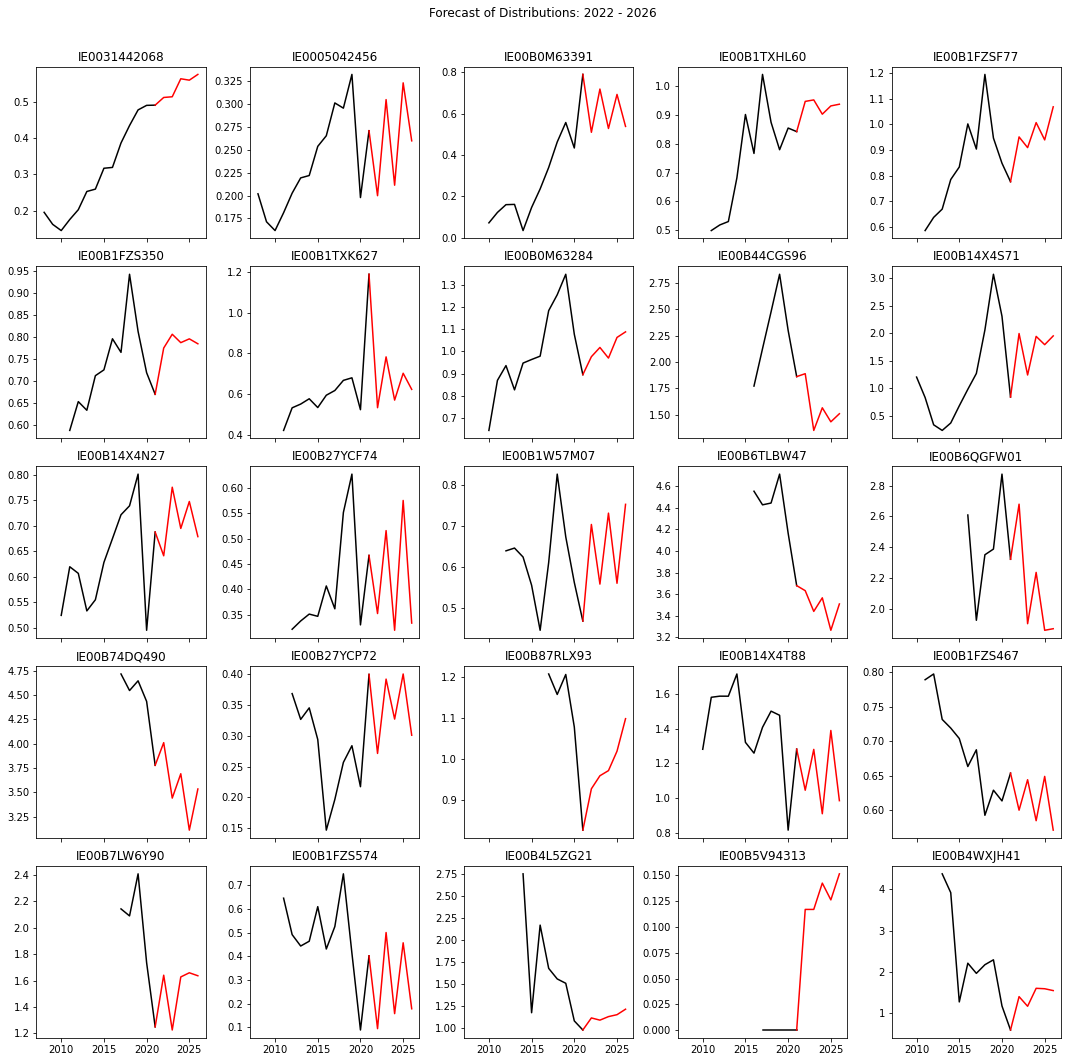

In [196]:
import matplotlib.pyplot as plt
import math

df_plot = df_pred_rf_optim.copy()

# Determine first year_base for predictions
# min_year_base = df_pred[df_pred.Year != df_pred.Year_Base].Year_Base.min()

# Loop over first 25 ETF products
fig, ax = plt.subplots(5, 5, figsize=(15, 15), sharex=True)
fig.tight_layout(h_pad=2)

colors = ['red', 'green', 'blue', 'orange', 'purple']

# Create tuples for plot locations
ax_loc = []
for r in range(5):
    for c in range(5):
        ax_loc.append((r, c))

for i_, isin_i in enumerate(isin_list): #[:25]):

    # isin_i = "IE00B296QM64"
    df_plot_i = df_plot[df_plot.Security_ISIN == isin_i].copy()

    df_plot_base = df_plot_i[df_plot_i.Year == df_plot_i.Year_Base].copy()

    # Reduce time horizon
    df_plot_base = df_plot_base[df_plot_base.Year >= (min_year_base - 4)]

    # Get coordinates of current subplot
    ax_x, ax_y = ax_loc[i_]

    ax[ax_x,ax_y].plot(df_plot_base['Year'], df_plot_base['Dist_Amount'], color='black')

    for i__, year_base_i in enumerate(range(2021, 2022)):
        df_plot_i_ = df_plot_i[df_plot_i.Year_Base == year_base_i]
        ax[ax_x,ax_y].plot(df_plot_i_['Year'], df_plot_i_['Dist_Amount'], color=colors[i__])

    ax[ax_x,ax_y].set_title(isin_i)

fig.suptitle('Forecast of Distributions: 2022 - 2026')
plt.subplots_adjust(top=0.925)

plt.savefig('graphics/predict_dist_topdown_predict_outofsample.png')

plt.show()




## Model Sensitivity Analysis

How does the model behave when assumptions change?


For a given set of observations in last 4 periods:
* Vary each feature and inspect the reaction of the model


This is important to understand if the model is well-behaved:
* Identification of jumpy behavior
* Expected reaction
* Creation of outliers, erratic behavior